# Emotion Analysis for Screenplays

In [1]:
import os
import re
import paralleldots
import numpy as np
import matplotlib.pyplot as plt
from nltk import tokenize
from nltk import sent_tokenize
from scipy.stats import linregress

api_key = "Y20zGrNXKCAEHNAZm61l2EEutnnvNLgacWuaT1rr19U"
paralleldots.set_api_key(api_key)


In [55]:
def parse():
    for root, dirs, files in os.walk('imsdb'):
        for file in files:
            if file != ".DS_Store":
                sentences = []
                path = root + "/" + file
    #path = "imsdb/Adventure/adventuresofbuckaroobanzaiacrosstheeighthdimensionthe.txt"
                curr_string = ""
                with open(path, 'r') as f:
                    for line in f:
                        line = line.strip() # deletes all leading white spaces/tabs/newlines from front/back
                        if len(line) > 1 and not line.isupper(): # we only want to copy lines that have something in it
                            #sentence_parts_sentence = ""
                            #sentence_parts_sentence = re.sub(r'\b[A-Z]+\b', '', line) # replace all capital letters with nothing
                            line = line.lower()
                            sentence_parts_temp = re.split(r"[.!?]", line) # split by end of sentence
                            sentence_parts = []
                            for sentence in sentence_parts_temp:
                                sentence_parts.append(sentence.strip())
                            sentence_parts = [x for x in sentence_parts if x]
                            if len(sentence_parts) > 0:
                                curr_string += " " + sentence_parts[0]
                                curr_string = curr_string.strip()
                                if len(sentence_parts) == 1:
                                    if line.endswith(".") or line.endswith("?") or line.endswith("!") or line.endswith("..."):
                                        sentences = check_length(curr_string, sentences)
                                        curr_string = ""
                                else:
                                    sentences = check_length(curr_string, sentences)
                                    for i in range(1, len(sentence_parts)-1):
                                        sentences = check_length(sentence_parts[i], sentences)
                                    if line.endswith(".") or line.endswith("?") or line.endswith("!") or line.endswith("..."):
                                        sentences = check_length(sentence_parts[-1], sentences)
                                        curr_string = ""
                                    else:
                                        curr_string = sentence_parts[-1]

            
                path_output = "parsed2_imsdb/" + root.split('/')[-1] + "/" + file
        
                with open(path_output, "w") as text_file:
                    for sentence in sentences:
                        print("{}".format(sentence), file=text_file)

def check_length(sentence, sentences):
    sentence = sentence.replace('\'','')
    sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)", " ", sentence).split())
    words_in_sentence = sentence.split()
    if (len(words_in_sentence) > 2): 
        if (len(words_in_sentence) > 30):
            first = words_in_sentence[:30]
            first = ' '.join(first)
            sentences.append(first.strip())
            if (len(words_in_sentence[30:]) > 2):
                second = words_in_sentence[30:]
                second = ' '.join(second)
                sentences.append(second.strip())
        else:
            sentences.append(sentence)
    return sentences
    

In [44]:
def create_list():
    fileName = "parsed_imsdb/Action/2012.txt"
    file = open(fileName, 'r')
    script_as_list = []
    for line in file.readlines():
        line = line.strip()
        script_as_list.append(line)
    return script_as_list

In [47]:
def emotional_analysis(script_list):
    results = paralleldots.batch_emotion(script_list)
    print(results)
    list_of_lines = results["emotion"]
    major_emotions = []
    for line in list_of_lines:
        new_dict = {}
        for key, val in line.items():
            if val > 0.25:
                new_dict[key] = val
        major_emotions.append(new_dict)
    print(major_emotions)
    
    

In [56]:
out = parse()

In [114]:
def graphEmotions(data):
    data = np.loadtxt(data)
    averages = []
    averages2 = []
    num_points = int(data[:,1].shape[0]/40)
    
    first_emotion = data[:,1]
    print(num_points)
    for i in range(num_points):
        average = np.mean(first_emotion[i*40:i*40+40])
        averages.append(average)
    plt.plot(averages)
    
    second_emotion = data[:,4]
    print(num_points)
    for i in range(num_points):
        average2 = np.mean(second_emotion[i*40:i*40+40])
        averages2.append(average2)
    plt.plot(averages2)
    plt.ylabel('probability')
    plt.show()
    plt.savefig('hangoverworry.png')

50
50


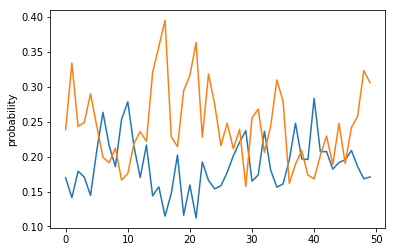

<Figure size 432x288 with 0 Axes>

In [115]:
graphEmotions("hangover_emotion.txt")

In [64]:
def extractFeatures1_2(data):
    
    #Sadness, Worry, Love, Hate, Happiness Neutral
    
    data = np.loadtxtt(data)
    # feature 1: means of each emotion for particular movie
    average_emotion = np.mean(data, axis=0)
    print(average_emotion)
    
    # feature 2: slope of of each emotion for particular movie
    x_points = list(range(data.shape[0])) 
    slope_emotion = []
    for emotion in range(len(data[1])):
        y_points = data[:,emotion]
        slope_emotion.append(linregress(x_points, y_points).slope)
    print(slope_emotion)

In [65]:
extractFeatures1_2("hangover_emotion.txt")

[0.10353284 0.1878703  0.05754881 0.03819915 0.24470522 0.36814368]
[1.4610870748545322e-05, 7.70095290392072e-06, 3.2689280965193053e-06, 6.903290363704038e-06, -1.290503400627907e-05, -1.9579008615428344e-05]


In [27]:
def extractFeatures3_4(data):
    data = np.loadtxt(data)
    # feature 3: means of each emotion in each act for particular movie
    # feature 4: slopes of each emotion per act
    index_1 = int(data.shape[0] / 4)
    index_2 = 3 * index_1
    
    
    # --- first act 
    average_emotion_first_act = np.mean(data[:index_1], axis = 0)
    x_points = list(range(index_1))
     
    slope_emotion_first_act = []
    for emotion in range(len(data[1])):
        y_points = data[:index_1,emotion]
        slope_emotion_first_act.append(linregress(x_points, y_points).slope)
    
    print(average_emotion_first_act)
    print(slope_emotion_first_act)
    
    # --- second act 
    average_emotion_sec_act = np.mean(data[index_1:index_2], axis = 0)
    x_points = list(range(index_1, index_2))
     
    slope_emotion_sec_act = []
    for emotion in range(len(data[1])):
        y_points = data[index_1:index_2,emotion]
        slope_emotion_sec_act.append(linregress(x_points, y_points).slope)
        
    print(average_emotion_sec_act)
    print(slope_emotion_sec_act)
    
    # --- third act 
    average_emotion_third_act = np.mean(data[index_2:], axis = 0)
    x_points = list(range(index_2, data.shape[0]))
     
    slope_emotion_third_act = []
    for emotion in range(len(data[1])):
        y_points = data[index_2:,emotion]
        slope_emotion_third_act.append(linregress(x_points, y_points).slope)
        
    
    print(average_emotion_third_act)
    print(slope_emotion_third_act)

In [28]:
extractFeatures3_4("fakedata.txt")

[0.46280353 0.51355233 0.50768747 0.51067228 0.49410022 0.49588014
 0.48053664 0.51161197 0.52453371 0.47090209]
[0.00018697855679963382, 3.315758404256073e-05, -0.0001729084400798247, 0.00019486429792831922, -2.3838390676227267e-05, -5.829327046844163e-05, -0.00014113892735357941, -0.00029054038593338176, -0.00035992053247385495, 0.0001889921867861994]
[0.48776677 0.49312562 0.50255933 0.49941153 0.47300864 0.50168402
 0.51594907 0.49991331 0.50108272 0.48595735]
[2.14457995124766e-05, 9.692988740554117e-06, -2.1145394148904543e-05, -2.791069207125088e-05, -8.413569299201653e-06, 0.00012293955334349526, 2.093060440467724e-05, -0.0002536255444440617, 0.0002203114892986951, 1.8369579496563643e-05]
[0.49203077 0.52060631 0.50769928 0.47689804 0.48494529 0.47453712
 0.50036289 0.52492963 0.47533807 0.51376894]
[0.0002254294052559273, -0.00018442859078595793, 8.450113545479885e-05, -0.0002664449135317764, -0.00044570574241557223, -0.0004581289956326012, -2.1623118444215268e-05, 0.000563887

In [29]:
def extractFeatures5(data):
    data = np.loadtxt(data)
    #feature 5: deltas betwen average emotions of each of 8 sequences
    seq_length = int(data.shape[0] / 8)
    midpoint_delta = np.zeros((8,10)) # 8 sequences, 10 deltas for each emotion
    sec_act_delta = np.zeros((8,10))
    
    #find average of midpoint
    average_mp = np.mean(data[int((data.shape[0]/2)-(seq_length/2)):int((data.shape[0]/2)+(seq_length/2))], axis = 0)
    
    #find average of end of second act
    average_sec = np.mean(data[int((data.shape[0]*3/4)-(seq_length/2)):int((data.shape[0]*3/4)+(seq_length/2))], axis = 0)
    
    for i in range(8):
        j = i*seq_length
        average_emotion = np.mean(data[j:j+seq_length], axis = 0)
        delta_mp = average_mp - average_emotion
        delta_sec = average_sec - average_emotion
        midpoint_delta[i] = delta_mp
        sec_act_delta[i] = delta_sec
    print(midpoint_delta)
    print(sec_act_delta)

    

In [30]:
extractFeatures5("fakedata.txt")

[[ 0.03030897 -0.03377186 -0.04134749  0.05101785 -0.02962277  0.0106099
   0.00459769 -0.07630363 -0.04813729  0.01835624]
 [ 0.00464245 -0.07343714 -0.01510347  0.02502149 -0.00239055  0.01307237
   0.04498301 -0.0333917  -0.00145579 -0.02787318]
 [ 0.00387116 -0.02823258 -0.0442923   0.04550211 -0.01424491  0.0108502
  -0.03206779 -0.09344069  0.04412425 -0.00293584]
 [-0.02677885 -0.0512433   0.00047888  0.05718295  0.0337554   0.04247584
   0.01363281 -0.07315265  0.00809033 -0.04433346]
 [ 0.01251247 -0.01958913 -0.03321928  0.02654029  0.00281597 -0.02231939
   0.00335651 -0.01963137 -0.01491863 -0.01833687]
 [-0.01955493 -0.03364611 -0.01535665  0.06789633 -0.00198679 -0.00685762
  -0.02740983  0.01362868 -0.04267812 -0.01364873]
 [ 0.02411024 -0.07064469 -0.03571638  0.06437364 -0.03668827  0.00199258
  -0.00626095 -0.03734475  0.0388655  -0.05407342]
 [-0.04761332 -0.05067226 -0.0207582   0.07921416  0.02298481  0.06437573
   0.01618915 -0.0989859   0.00993272 -0.04117721]]
[

In [31]:
def extractFeatures6(data):
    data = np.loadtxt(data)
    # feature 6: variance of each emotion 
    var_emotion = np.var(data, axis=0)
    
    print(var_emotion)
    

In [32]:
extractFeatures6("fakedata.txt")

[0.08094742 0.08587967 0.08195805 0.07992966 0.08257502 0.08854046
 0.08197477 0.08364028 0.0823631  0.08309012]


In [6]:
import pandas as pd
import csv

def makeToCSV():
    for root, dirs, files in os.walk('parsed2_imsdb'):
        for file in files:
            if file != ".DS_Store":
                path = root + "/" + file                    
                with open(path, 'r') as in_file:
                    #lines = ["sentence"] + in_file.readlines()
                    
                    for line in lines.readlines():
                        print(line)
                    path_output = "parsed3_imsdb/" + root.split('/')[-1] + "/" + file + ".csv";
                    print(path_output)
#                     with open(path_output + file + ".csv", "w") as out_file:
                        
#                         writer = csv.writer(out_file)
#                         writer.writerows(lines)
            


In [7]:
makeToCSV()

NameError: name 'lines' is not defined